# Cliopatria viewer

1. To get started, download a copy of the Cliopatria dataset from here: `[INSERT LINK]`
2. `(OPTIONAL)` You can also download the GADM modern borders dataset from here `[INSERT LINK]`
3. Move the downloaded shape dataset(s) to an appropriate location on your machine and pass in the paths in the code cell below and run
4. Run the subsequent cells of the notebook


In [15]:
# cliopatria_path = "path/to/cliopatria_dir/"
# gadm_path = "path/to/gadm_410.gpkg"
cliopatria_geojson_path = "../data/cliopatria_05192024/cliopatria.geojson"
cliopatria_json_path = "../data/cliopatria_05192024/name_years.json"
gadm_path = "../data/gadm_410.gpkg"

In [2]:
import geopandas as gpd

# Load the geojson file
gdf = gpd.read_file(cliopatria_geojson_path)

# Display the loaded data
print(gdf.head())

                             Name  Year      Area_km2    Type  \
0            Sumerian City-States -3400  22083.609657  POLITY   
1            Sumerian City-States -3200  35508.841506  POLITY   
2                            Elam -3200   4919.440675  POLITY   
3            Sumerian City-States -3000  45135.556672  POLITY   
4  Early Dynastic Period of Egypt -3000  92480.979261  POLITY   

                       Wikipedia     Color      SeshatID Member_of Components  \
0               History of Sumer  0x800000                                      
1               History of Sumer  0x800000                                      
2                           Elam  0xd9b800                                      
3               History of Sumer  0x800000                                      
4  Early Dynastic Period (Egypt)  0x808000  eg_dynasty_1                        

                                            geometry  
0  POLYGON ((46.58681 31.27192, 46.43482 31.27192...  
1  POLYGON (

In [16]:
# Load the name_years json file
import json
with open(cliopatria_json_path, 'r') as f:
    name_years = json.load(f)

In [17]:
# Add the EndYear column to the geodataframe

# Create a new column in the geodataframe
gdf['EndYear'] = None

# Loop through the geodataframe
for i in range(len(gdf)):
    # Get the name of the current row
    polity_name = gdf.loc[i, 'Name']

    # Get the start year of the current row
    start_year = gdf.loc[i, 'Year']

    # Get a sorted list of the years for that name from the geodataframe
    this_polity_years = sorted(gdf[gdf['Name'] == polity_name]['Year'].unique())

    # Get the end year for a shape    
    # Most of the time, the shape end year is the year of the next shape
    # Some polities have a gap in their active years
    # For a shape year at the start of a gap, set the end year to be the shape year, so it doesn't cover the inactive period
    start_end_years = name_years[polity_name]
    end_years = [x[1] for x in start_end_years]

    polity_start_year = start_end_years[0][0]
    polity_end_year = end_years[-1]

    # Raise an error if the shape year is not the start year of the polity
    if this_polity_years[0] != polity_start_year:
        raise ValueError(f'First shape year for {polity_name} is not the start year of the polity')
    
    # Find the closest higher value from end_years to the shape year
    next_end_year = min(end_years, key=lambda x: x if x >= start_year else float('inf'))

    if start_year in end_years:  # If the shape year is in the list of polity end years, the start year is the end year
        end_year = start_year
    else:
        this_year_index = this_polity_years.index(start_year)  
        try:  # Try to use the next shape year minus one as the end year if possible, unless it's higher than the next_end_year
            next_shape_year_minus_one = this_polity_years[this_year_index + 1] - 1
            end_year = next_shape_year_minus_one if next_shape_year_minus_one < next_end_year else next_end_year
        except IndexError:  # Otherwise assume the end year of the shape is the end year of the polity
            end_year = polity_end_year

    # Set the EndYear column to the end year
    gdf.loc[i, 'EndYear'] = end_year

# Display the updated data
print(gdf.head())

                             Name  Year      Area_km2    Type  \
0            Sumerian City-States -3400  22083.609657  POLITY   
1            Sumerian City-States -3200  35508.841506  POLITY   
2                            Elam -3200   4919.440675  POLITY   
3            Sumerian City-States -3000  45135.556672  POLITY   
4  Early Dynastic Period of Egypt -3000  92480.979261  POLITY   

                       Wikipedia     Color      SeshatID Member_of Components  \
0               History of Sumer  0x800000                                      
1               History of Sumer  0x800000                                      
2                           Elam  0xd9b800                                      
3               History of Sumer  0x800000                                      
4  Early Dynastic Period (Egypt)  0x808000  eg_dynasty_1                        

                                            geometry EndYear  
0  POLYGON ((46.58681 31.27192, 46.43482 31.27192...   -320

In [18]:
# Filter the gdf for shapes that overlap with the year 0
filtered_gdf = gdf[(gdf['Year'] <= 0) & (gdf['EndYear'] >= 0)]

In [19]:
import matplotlib.pyplot as plt
import contextily as ctx

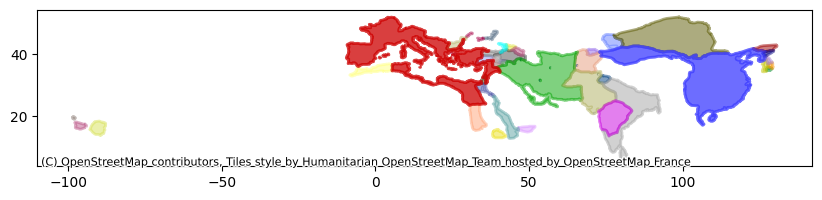

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

# Remove '0x' and add '#' to the start of the color strings
colors = '#' + filtered_gdf['Color'].str.replace('0x', '')

# Plot the polygons with colors based on the 'Color' field
filtered_gdf.plot(ax=ax, linewidth=2, edgecolor=colors, facecolor=colors, alpha=0.5)

# Add a basemap
ctx.add_basemap(ax, crs=filtered_gdf.crs.to_string())

plt.show()